## Demo notebook for New Zealand Wildlife Thermal Imaging

This notebook demonstrates basic interaction with video clips from the New Zealand Wildlife Thermal Imaging dataset.

### Constants and imports

In [39]:
import os
import json
import random

from collections import defaultdict
from tqdm import tqdm
from IPython.display import Video

# Change this to point to the folder where you placed all the data
base_folder = os.path.expanduser('/home/user/tmp/cacophony-thermal-out')
hdf_folder = '/bigdata/home/sftp/cacophony-ferraro_/data/cacophony-thermal/'
main_metadata_filename = 'new-zealand-thermal-wildlife-imaging.json'

random.seed(0)

### Open the metadata file, print some statistics

In [2]:
with open(os.path.join(base_folder,main_metadata_filename),'r') as f:
    metadata = json.load(f)

# Print basic info about the dataset    
for k in metadata:
    print('{}: {}'.format(k,metadata[k]))
    
# From now on, we only care about the 'clips' field    
all_clip_metadata = metadata['clips']
print('Read metadata for {} clips'.format(len(all_clip_metadata)))

# Count the number of videos associated with each label    
label_to_video_count = defaultdict(int)

for clip_metadata in tqdm(all_clip_metadata):
    
    if clip_metadata['error'] is not None:
        continue
     
    # This will be a list of labels attached to this video
    labels_this_clip = set()
    
    # Labels are actually assigned to *track* (individual moving blobs), so
    # look at all the tracks that were labeled on this video.
    for track_info in clip_metadata['tracks']:
        for tag in track_info['tags']:
            tag_label = tag['label']
            labels_this_clip.add(tag_label)
    
    for label in labels_this_clip:
        label_to_video_count[label] += 1
              
# Print labels in descending order of frequency            
label_to_video_count = {k: v for k, v in sorted(label_to_video_count.items(), 
                                                key=lambda item: item[1], reverse=True)}

print('Labels:\n')

for label in label_to_video_count:
    print('{}: {}'.format(label,label_to_video_count[label]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|████████████████████████████████████████████████████████| 121190/121190 [00:00<00:00, 842010.96it/s]

Labels:

false-positive: 24109
rodent: 22941
bird: 22704
possum: 13616
mustelid: 8937
leporidae: 7001
hedgehog: 5283
human: 4490
cat: 3408
wallaby: 2809
unidentified: 2404
vehicle: 2162
mouse: 1809
stoat: 1638
insect: 1253
bird/kiwi: 950
rabbit: 797
rat: 741
dog: 495
poor tracking: 426
other: 400
sheep: 353
part: 337
penguin: 312
pest: 280
kiwi: 246
deer: 119
black swan: 102
duck: 64
lizard: 29
pukeko: 22
goat: 21
ferret: 17
north island brown kiwi: 10
brown quail: 9
hare: 7
chicken: 5
not identifiable: 4
little spotted kiwi: 3
pheasant: 2
song thrush: 1
california quail: 1
partridge: 1
morepork: 1
pig: 1
allbirds: 1
brown teal: 1
sealion: 1
quail: 1
new zealand fantail: 1


## Choose a clip to tinker with

Run this cell and subsequent cells multiple times to tinker with multiple videos.  By default we fix the random seed in the first cell of this notebook, so you will get the same sequence every time you run this notebook.

In [34]:
# Useful example for testing this notebook on a clip with multiple tracks
i_clip = 8

# i_clip = random.randint(0,len(all_clip_metadata)-1)
# i_clip = 110680

clip = all_clip_metadata[i_clip]
assert clip['error'] is None, 'Oops, you had the bad luck of randomly choosing an invalid clip'

print('Tinkering with clip {}:\n'.format(i_clip))

# Print information about this clip
for k in clip:
    if k == 'tracks':
        print('Tracks:')
        for track in clip['tracks']:
            print('  ' + str(track))
    elif k == 'calibration_frames':
        print('N calibration frame: {}'.format(len(clip['calibration_frames'])))
    else:
        print('{}: {}'.format(k,clip[k]))

Tinkering with clip 8:

hdf_filename: 409532.hdf5
id: 409532
error: None
Tracks:
  {'start_frame': 164, 'end_frame': 316, 'tags': [{'label': 'cat', 'confidence': 0.85}]}
  {'start_frame': 88, 'end_frame': 118, 'tags': [{'label': 'cat', 'confidence': 0.85}]}
  {'start_frame': 140, 'end_frame': 174, 'tags': [{'label': 'cat', 'confidence': 0.85}]}
  {'start_frame': 111, 'end_frame': 139, 'tags': [{'label': 'cat', 'confidence': 0.85}]}
width: 158
height: 118
frame_rate: 9
labels: ['cat']
video_filename: 409532.mp4
filtered_video_filename: 409532_filtered.mp4
location: 258
N calibration frame: 0
metadata_filename: 409532_metadata.json


### Play the videos file associated with this clip

#### First the normalized (but not background-corrected) video

In [35]:
video_filename = os.path.join(base_folder,clip['video_filename'])
assert os.path.isfile(video_filename)

print('Playing non-background-corrected video ({}):'.format(video_filename))
Video(video_filename,embed=True,width=500)

Playing non-background-corrected video (/home/user/tmp/cacophony-thermal-out/409532.mp4):


### Now the background-corrected video

In [36]:
filtered_video_filename = os.path.join(base_folder,clip['filtered_video_filename'])
assert os.path.isfile(filtered_video_filename)

print('Playing background-corrected video ({}):'.format(filtered_video_filename))
Video(filtered_video_filename,embed=True,width=500)

Playing background-corrected video (/home/user/tmp/cacophony-thermal-out/409532_filtered.mp4):


### Render the tracks associated with this clip

These should match whatever moving blobs you just saw in the video.  These are not stored in the main metadata file (because they make it very large, and you don't *need* this information for most things you might do with this dataset), so we need to load the metadata file for this specific file.

start_frame: 164
end_frame: 316
tags: [{'label': 'cat', 'confidence': 0.85}]
153 points
start_frame: 88
end_frame: 118
tags: [{'label': 'cat', 'confidence': 0.85}]
31 points
start_frame: 140
end_frame: 174
tags: [{'label': 'cat', 'confidence': 0.85}]
35 points
start_frame: 111
end_frame: 139
tags: [{'label': 'cat', 'confidence': 0.85}]
29 points


(0.0, 118.0)

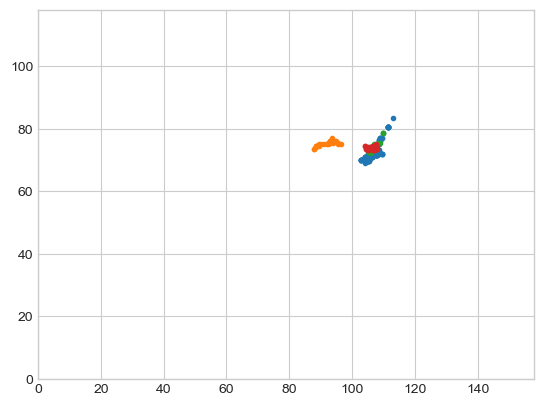

In [37]:
clip_metadata_filename = clip['metadata_filename']
with open(os.path.join(base_folder,clip_metadata_filename)) as f:
    clip_metadata_with_position = json.load(f)

# Print some basic metadata about each track, and plot them
for track in clip_metadata_with_position['tracks']:
    for k in track:
        if k == 'points':
            print('{} points'.format(len(track['points'])))
        else:
            print('{}: {}'.format(k,track[k]))

# A list of (x[],y[]) tracks
track_coords = []
for track in clip_metadata_with_position['tracks']:
    # These are organized as x/y/frame    
    points = track['points']
    x = [p[0] for p in points]
    y = [(clip['height'] - p[1]) for p in points]
    track_coords.append((x,y))
    
import matplotlib.pyplot as pl
for t in track_coords:
    x = t[0]
    y = t[1]
    plt.plot(x,y,'.')
plt.xlim([0, clip['width']])
plt.ylim([0, clip['height']])

### Explore the HDF file associated with this clip

It's unlikely you'll need anything from the HDF file if you're doing Machine Learning Stuff (tm) with this dataset, but just in case...

clip_id: 409532
crop_rectangle: array of length 4
ffc_frames: array of length 0
frame_temp_max: array of length 395
frame_temp_mean: array of length 395
frame_temp_median: array of length 395
frame_temp_min: array of length 395
max_temp: 3058
mean_temp: 2637
min_temp: 2607
num_frames: 395
res_x: 160
res_y: 120
start_time: 2019-10-22T00:24:33.871072+13:00
station_id: 258


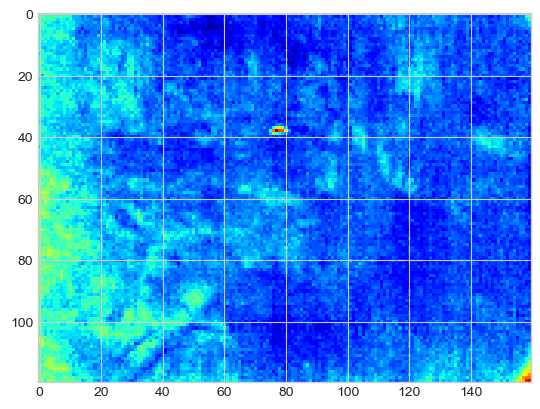

In [46]:
import h5py
import numpy as np

h5f = h5py.File(os.path.join(hdf_folder,clip['hdf_filename']),'r')

# Print the metadata in the HDF file
clip_attrs = h5f.attrs
for k in clip_attrs:
    if isinstance(clip_attrs[k],np.ndarray):
        print('{}: array of length {}'.format(k,len(clip_attrs[k])))
    else:
        print('{}: {}'.format(k,clip_attrs[k]))
        
# This is where the actual frames are, as an array of size nframes,x,y
thermal_frames = h5f['frames']['thermals']

assert clip_attrs.get('num_frames') == thermal_frames.shape[0]

# Show an image of the first frame
thermal_frames_array = np.array(thermal_frames)
sample_frame = thermal_frames_array[0]
plt.imshow(sample_frame,cmap='jet')